In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os, re, glob, cv2, numpy as np

dirs = os.listdir('/content/drive/My Drive/Dataset/')
label = 0
im_arr = []
lb_arr = []
X = []
y = []
for i in dirs: #loop all directory
    count = 0
    for pic in glob.glob('/content/drive/My Drive/Dataset/'+i+'/*'):
        im = cv2.imread(pic)
        im = cv2.resize(im,(224,224))
        im = np.array(im)
        count = count + 1
        X.append(im)
        y.append(label)
        if(count <= 10):
            im_arr.append({str(i):im})
    print("Jumlah "+str(i)+" : "+str(count))
    label = label + 1
    lb_arr.append(i)
X = np.array(X)
y = np.array(y);

Jumlah kupu_raja_helena : 100
Jumlah kupu_pantat_merah : 95
Jumlah kupu_jojo : 100
Jumlah kupu_batik_cap : 100
Jumlah kupu_jarak : 100
Jumlah kupu_hijau_biru : 100
Jumlah kupu_harimau_kuning_hijau : 100
Jumlah kupu_raja_limau : 100


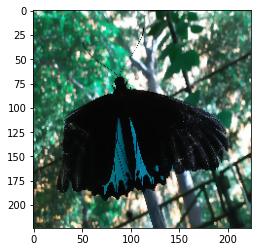

In [4]:
import matplotlib.pyplot as plt
plt.imshow(X[1])

In [6]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras 
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Input,Flatten,Lambda,Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.densenet import DenseNet121
from keras import backend as K

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
y_train = to_categorical(y_train, 8)
y_test = to_categorical(y_test, 8)
y_train.shape

(532, 8)

In [6]:
print(lb_arr)

['kupu_raja_helena', 'kupu_pantat_merah', 'kupu_jojo', 'kupu_batik_cap', 'kupu_jarak', 'kupu_hijau_biru', 'kupu_harimau_kuning_hijau', 'kupu_raja_limau']


In [8]:
IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 10
BATCH_SIZE = 8

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [11]:
pip install keras --upgrade

In [14]:
# https://github.com/Shanks0465/Resnext-DenseNet-Image-Captioning/blob/master/DenseNetFeatures.ipynb
import tensorflow as tf

dense_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape, classes = 8)
x = dense_model.output
x = Flatten()(dense_model.output)
x = Dense(512, activation="relu")(x)
prediction = Dense(8, activation="softmax")(x)
model = Model(inputs = dense_model.input,outputs=prediction)
adam = Adam(learning_rate=0.001)
model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='adam')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                           

In [17]:
# https://colab.research.google.com/github/hardik0/AI-for-Medicine-Specialization/blob/master/AI-for-Medical-Diagnosis/Week-1/Densenet.ipynb#scrollTo=5ToseMS7Di8u
# https://towardsdatascience.com/paper-review-densenet-densely-connected-convolutional-networks-acf9065dfefb

# Training

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import mnist

MODEL_DIR = "/content/drive/My Drive/DenseNet/temp"

if not os.path.exists(MODEL_DIR):  #If the directory does not exist, create it.
    os.makedirs(MODEL_DIR)
checkpoint = ModelCheckpoint(filepath = os.path.join(MODEL_DIR, "model-{epoch:02d}.h5"),
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

history = model.fit(X_train, y_train, epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, validation_data=(X_test, y_test), 
                    callbacks=[checkpoint])

scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 12.2492 - accuracy: 0.6203
Epoch 00001: val_accuracy improved from -inf to 0.07605, saving model to /content/drive/My Drive/DenseNet/temp/model-01.h5
67/67 [==============================] - 378s 6s/step - loss: 12.2492 - accuracy: 0.6203 - val_loss: 133335.3125 - val_accuracy: 0.0760
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 4.3725 - accuracy: 0.7237
Epoch 00002: val_accuracy improved from 0.07605 to 0.28517, saving model to /content/drive/My Drive/DenseNet/temp/model-02.h5
67/67 [==============================] - 366s 5s/step - loss: 4.3725 - accuracy: 0.7237 - val_loss: 103.8622 - val_accuracy: 0.2852
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 0.9669 - accuracy: 0.8590
Epoch 00003: val_accuracy improved from 0.28517 to 0.80989, saving model to /content/drive/My Drive/DenseNet/temp/model-03.h5
67/67 [==============================] - 365s 5s/step - loss: 0.9669 - acc

In [18]:
model_json=model.to_json()
with open("/content/drive/My Drive/DenseNet/temp/model.json","w") as file:
    file.write(model_json)
model.save_weights("/content/drive/My Drive/DenseNet/temp/my_model.h5")
print("Model berhasil disimpan !! ")

Model berhasil disimpan !! 


In [19]:
from tensorflow.keras.models import model_from_json
json_file = open('/content/drive/My Drive/DenseNet/temp/model.json','r')
loaded_model_json = json_file.read()
json_file.close()

load_model = model_from_json(loaded_model_json)
load_model.load_weights("/content/drive/My Drive/DenseNet/temp/my_model.h5")

print("Loadded!")

Loadded!


In [20]:
load_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                           

In [21]:
# Evaluate accuracy
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=1)

print('\nTest accuracy:', test_acc)

9/9 [==============================] - 31s 3s/step - loss: 0.0098 - accuracy: 0.9962

Test accuracy: 0.9961977005004883


In [22]:
train_loss, train_acc = model.evaluate(X_train,  y_train, verbose=1)

print('\nTrain accuracy:', train_acc)

17/17 [==============================] - 63s 4s/step - loss: 0.0085 - accuracy: 0.9962

Train accuracy: 0.9962406158447266


In [ ]:
# # Testing
# probabilities = model.predict_generator(test_generator, TEST_SIZE)
# for index, probability in enumerate(probabilities):
#     image_path = test_data_dir + "/" +test_generator.filenames[index]
#     img = mpimg.imread(image_path)
#     plt.imshow(img)
#     if probability > 0.5:
#         plt.title("%.2f" % (probability[0]*100) + "% dog")
#     else:
#         plt.title("%.2f" % ((1-probability[0])*100) + "% cat")
#     plt.show()

In [23]:
#Graph drawing
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

<Figure size 432x288 with 0 Axes>

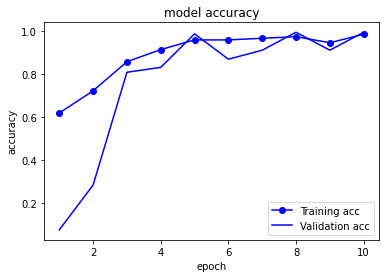

In [24]:
plot_epochs = range(1, len(acc)+1)
# Accuracy
plt.plot(plot_epochs, acc, 'bo-', label='Training acc')
plt.plot(plot_epochs, val_acc, 'b', label='Validation acc')
plt.title('model accuracy')
plt.ylabel('accuracy')  #Y-axis label
plt.xlabel('epoch')  #X-axis label
plt.legend()
plt.show()

In [25]:
y_pred = model.predict(X_test)

In [26]:
y_prediction_n = []
y_test_n = []
for i in range(0, len(y_pred)):
  max_n = max(y_pred[i])
  max_m = max(y_test[i])
  index_n = [index_n for index_n, j in enumerate(y_pred[i]) if j == max_n]
  index_m = [index_m for index_m, j in enumerate(y_test[i]) if j == max_m]
  y_prediction_n.append(index_n)
  y_test_n.append(index_m)

In [27]:
print(classification_report(y_test_n, y_prediction_n, 
                            target_names=["kupu_harimau_kuning_hijau",
                                          "kupu_raja_helena",
                                          "kupu_hijau_biru",
                                          "kupu_batik_cap",
                                          "kupu_jarak",
                                          "kupu_raja_limau",
                                          "kupu_jojo",
                                          "kupu_pantat_merah"]))

                           precision    recall  f1-score   support

kupu_harimau_kuning_hijau       1.00      1.00      1.00        39
         kupu_raja_helena       1.00      1.00      1.00        25
          kupu_hijau_biru       0.97      1.00      0.99        34
           kupu_batik_cap       1.00      0.97      0.99        37
               kupu_jarak       1.00      1.00      1.00        33
          kupu_raja_limau       1.00      1.00      1.00        32
                kupu_jojo       1.00      1.00      1.00        30
        kupu_pantat_merah       1.00      1.00      1.00        33

                 accuracy                           1.00       263
                macro avg       1.00      1.00      1.00       263
             weighted avg       1.00      1.00      1.00       263



In [28]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_pred

array([6, 6, 0, 5, 0, 7, 3, 6, 5, 6, 0, 2, 6, 0, 3, 3, 2, 6, 7, 6, 4, 5,
       6, 7, 6, 0, 2, 3, 6, 7, 2, 0, 5, 6, 0, 0, 6, 3, 7, 3, 1, 2, 1, 6,
       5, 5, 4, 4, 6, 4, 2, 1, 7, 5, 3, 3, 3, 7, 2, 1, 4, 4, 6, 4, 2, 5,
       0, 5, 3, 0, 5, 1, 7, 0, 0, 2, 5, 5, 6, 7, 7, 1, 0, 0, 5, 3, 7, 4,
       3, 0, 3, 7, 4, 7, 6, 6, 7, 5, 0, 7, 1, 4, 0, 1, 0, 2, 3, 7, 2, 7,
       4, 4, 0, 0, 7, 1, 2, 4, 2, 2, 4, 7, 1, 7, 2, 2, 2, 0, 2, 2, 6, 7,
       0, 6, 4, 6, 7, 4, 6, 4, 2, 5, 4, 2, 0, 5, 1, 3, 5, 3, 3, 0, 3, 4,
       5, 5, 4, 7, 5, 3, 2, 4, 3, 4, 3, 0, 1, 5, 3, 3, 7, 7, 1, 3, 2, 4,
       0, 4, 6, 7, 6, 6, 2, 2, 3, 0, 6, 3, 2, 6, 6, 3, 2, 5, 3, 0, 7, 1,
       4, 3, 2, 1, 0, 5, 1, 0, 0, 7, 4, 3, 4, 1, 0, 1, 1, 0, 6, 1, 2, 5,
       5, 1, 4, 5, 1, 5, 0, 3, 7, 0, 5, 4, 1, 2, 2, 2, 3, 3, 1, 5, 5, 4,
       7, 4, 0, 4, 1, 7, 0, 2, 7, 4, 2, 2, 5, 3, 0, 5, 3, 3, 0, 6, 7])

In [29]:
y_test_class = np.argmax(y_test, axis=1)

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
print(accuracy_score(y_test_class, y_pred))
confusion_matrix(y_test_class, y_pred)

0.9961977186311787


array([[39,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 25,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 34,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 36,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 33,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 32,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 30,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33]])

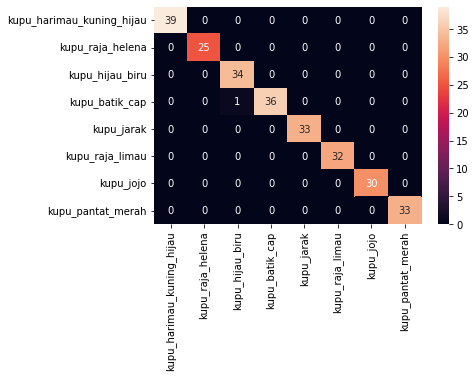

In [31]:
cm = confusion_matrix(y_test_class, y_pred)
sn.heatmap(cm, annot=True, xticklabels=["kupu_harimau_kuning_hijau",
                                          "kupu_raja_helena",
                                          "kupu_hijau_biru",
                                          "kupu_batik_cap",
                                          "kupu_jarak",
                                          "kupu_raja_limau",
                                          "kupu_jojo",
                                          "kupu_pantat_merah"], 
           yticklabels=["kupu_harimau_kuning_hijau",
                                          "kupu_raja_helena",
                                          "kupu_hijau_biru",
                                          "kupu_batik_cap",
                                          "kupu_jarak",
                                          "kupu_raja_limau",
                                          "kupu_jojo",
                                          "kupu_pantat_merah"])

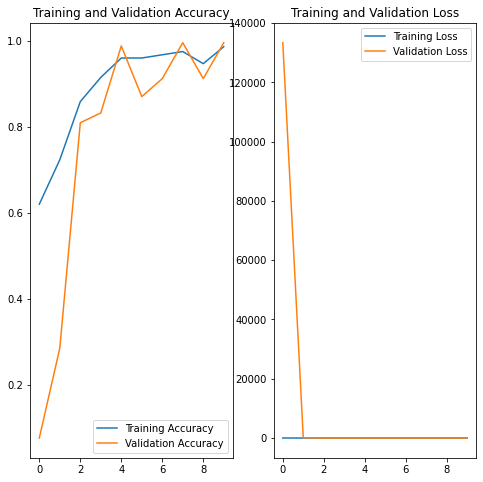

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()